Formateo los datos

In [33]:
import pandas as pd


def format_pd(data, intento):

    data = data[data["Intento"] == intento].copy() 

    # Esto es para que arranque en 365 una vez (lo hizo chat obviamente)
    mask = (data['x'] != 365.00) | (data['x'].shift(-1) != 365.00)

    data = data[mask]

    data["t"] = data["t"] - data["t"].min()

    data = data.drop(columns=["Intento"])
    
    return data

Este lo chorie del campus

Aceleración a: 0.0 ± 0.0 m /s^2
Velocidad inicial v_0: -0 ± 0 m /s
Posición inicial x_0: 437 ± 0m


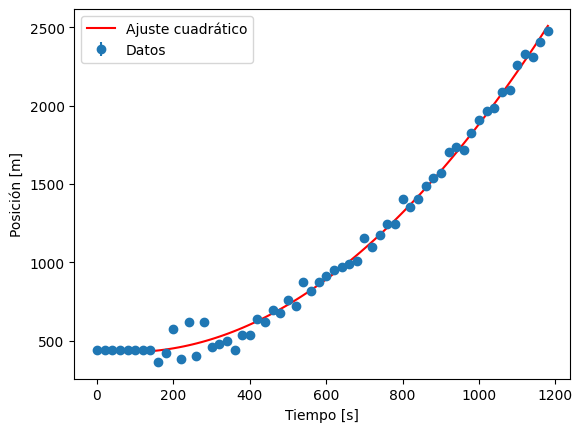

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

datasets = ['data_dosplata_oro_PAPEL.csv', 'data_dosplataymadera_oro.csv', 'data_maderayoro_dosplata.csv', 'data_plata_dosplata.csv', 'data_tresplata_oro_PAPEL.csv' ] 

data = pd.read_csv(datasets[4])

f_data = format_pd(data=data, intento=1)


tiempo = f_data["t"].values
posicion = f_data["x"].values
errores_y =  1
errores_x = 1


# Definir la función cuadrática con v_0 = 0
def modelo_cuadratico(t, a, v_0, x_0):
    return a * t**2 + v_0 * t +  x_0

# Ajustar la curva
popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores_y, absolute_sigma=True)

# Obtener los coeficientes ajustados y sus errores
a_opt, v_0_opt, x_0_opt = popt
errores = np.sqrt(np.diag(pcov))

print(f"Aceleración a: {a_opt:.1f} ± {errores[0]:.1f} m /s^2")
print(f"Velocidad inicial v_0: {v_0_opt:.0f} ± {errores[1]:.0f} m /s")
print(f"Posición inicial x_0: {x_0_opt:.0f} ± {errores[2]:.0f}m")

# Graficar los datos y el ajuste
t_ajuste = np.linspace(tiempo.min(), tiempo.max(), 100)
plt.errorbar(tiempo, posicion, yerr=errores_y, fmt='o', label='Datos')

plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'r', label=f'Ajuste cuadrático')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')
plt.legend()
plt.show()


# Este esta muy bueno

el problema es que curve_fit toma sólo sigma en Y (no en X)

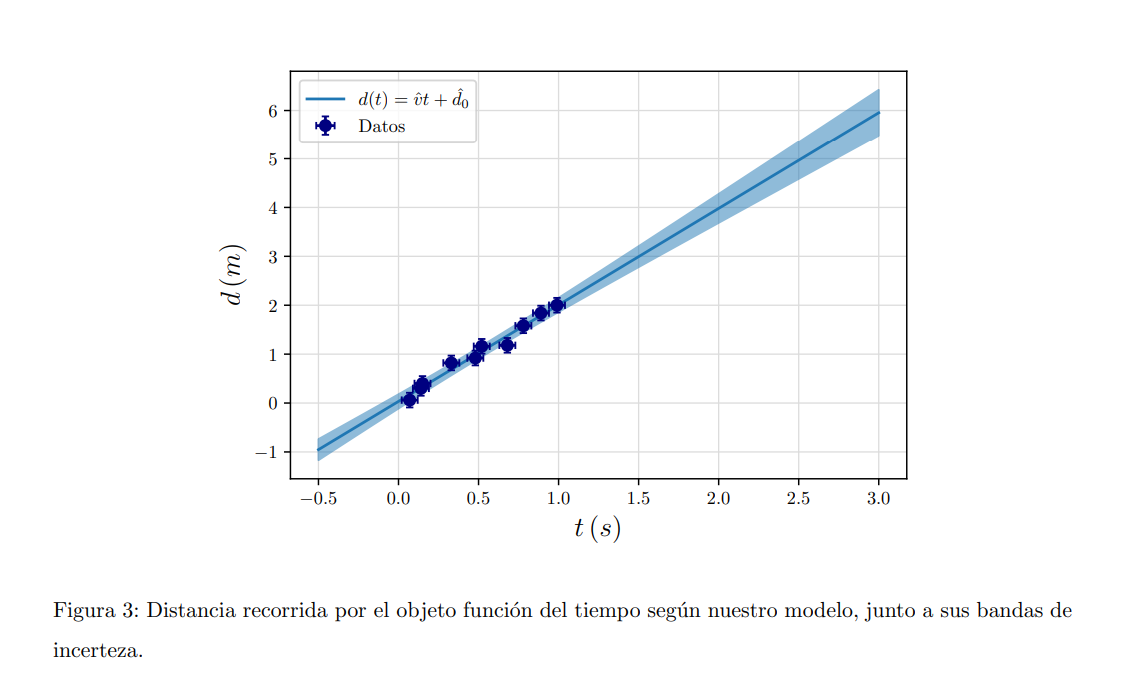

El loco usa esto, pero como estamos fitteando una cuadrática la función es un quilombo, así que use la que nos dio pato. Lo que pasa es que esto te da un valor en base a F (por eso quedan bandas) mientras que la fórmula de pato te da un sigma z, que despues queda como "constante" en el ploteo (no depende de t)

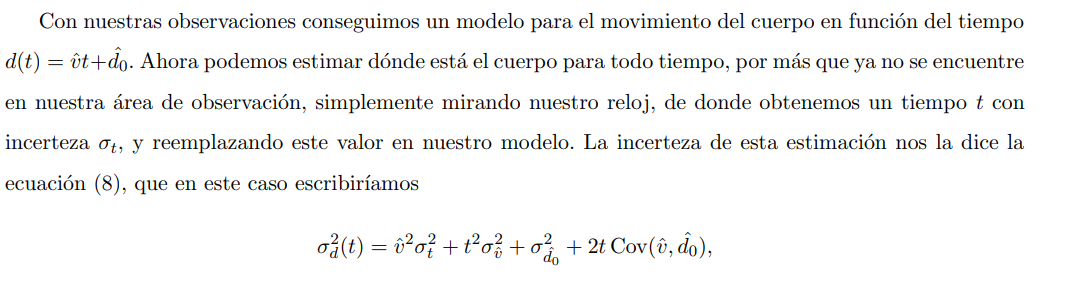

In [35]:
def f_propagacion_errores(t, popt, error_x):

    a, b, c = popt

    sum = 0
    for i in range(len(t)):
        df_dx = 2 * i * a + b
        sum += df_dx**2 * error_x**2

        
    
    return np.sqrt(sum)

La incerteza en la posición es: 1.4334463598766622


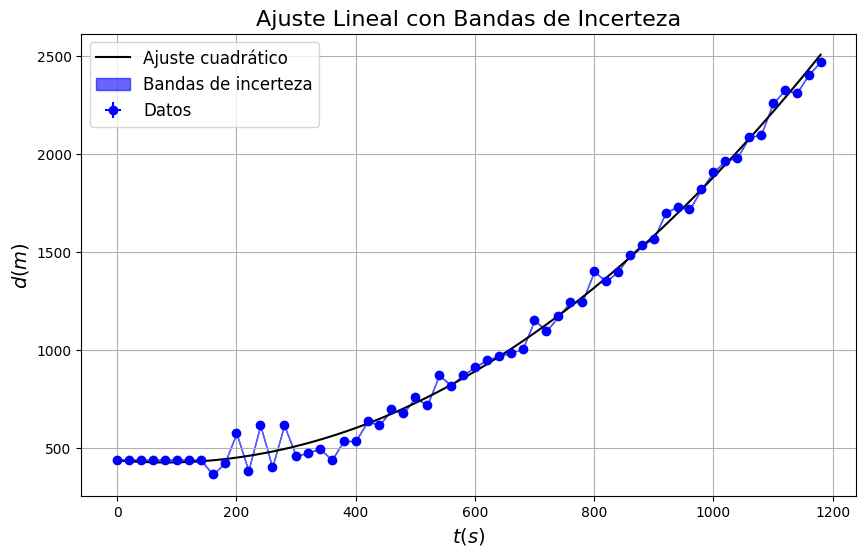

In [36]:
popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores_y, absolute_sigma=True)

# Extract the fitted parameters and their uncertainties
a1, a2, b = popt
errores = np.sqrt(np.diag(pcov))




# Use the provided parameters and covariance
sigma_d_t = f_propagacion_errores(tiempo, popt, errores_x)

print(f"La incerteza en la posición es: {sigma_d_t}")
plt.figure(figsize=(10, 6))
plt.errorbar(tiempo, posicion, xerr=errores_x, yerr=errores_y, fmt='o', color='blue', label='Datos')

plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'black', label=f'Ajuste cuadrático')

# Arreglar esto xfa
plt.fill_between(tiempo, posicion + sigma_d_t , posicion - sigma_d_t, color='blue', alpha=0.6, label='Bandas de incerteza')

# Customize the plot
plt.xlabel(r'$t(s)$', fontsize=14)
plt.ylabel(r'$d(m)$', fontsize=14)
plt.title('Ajuste Lineal con Bandas de Incerteza', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.show()
